### Protocol 1 D12 vs. D24 feature selection

In [1]:
library(boot)
library(glmnet)
library(ggplot2)
library(dplyr)
library(gridExtra)
library(glue)

Loading required package: Matrix

Loading required package: foreach

Loaded glmnet 2.0-18



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




In [2]:
options(stringsAsFactors = FALSE)

In [3]:
SAVE=TRUE

PNG_DIR = "plots/pngs"
SVG_DIR = "plots/svgs"
PDF_DIR = "plots/heatmap_pdfs"

if (SAVE) {
    dir.create("plots/pngs")
    dir.create("plots/svgs")
    dir.create("plots/heatmap_pdfs")
}

Warning message in dir.create("plots/pngs"):
“'plots/pngs' already exists”
Warning message in dir.create("plots/svgs"):
“'plots/svgs' already exists”
Warning message in dir.create("plots/heatmap_pdfs"):
“'plots/heatmap_pdfs' already exists”


In [4]:
get_gene_name <- function(name){
    gene_name <- unlist(strsplit(name, '_'))
    name_length <- length(gene_name)
    return(paste((gene_name[-name_length]), collapse = "_"))
}

In [5]:
load("/allen/aics/gene-editing/RNA_seq/scRNAseq_SeeligCollaboration/2019_analysis/feature_selection/train_cm_entrez_only_normalized_counts.RData")

In [6]:
cell_metadata <- read.csv("/allen/aics/gene-editing/RNA_seq/scRNAseq_SeeligCollaboration/2019_analysis/feature_selection/train_cm_entrez_only_metadata.csv")

In [7]:
base_dir <- "/allen/aics/gene-editing/RNA_seq/scRNAseq_SeeligCollaboration/2019_analysis/feature_selection/"

In [8]:
load(paste0(base_dir, "results/early_late_small_mol.RData"))

In [9]:
lambda_sequence <- bootstraps[[1]][["lambda"]]
genes <- rownames(coef(bootstraps[[1]], s = lambda_sequence[1]))

In [10]:
genes <- genes[2:length(genes)]
length(genes)
num_genes <- length(genes)

[1] 23665

In [11]:
nonzero_gene_count <- c()
lambda <- lambda_sequence[50]

genes_coeff <- coef(bootstraps[[1]], s = lambda)
genes_coeff <- genes_coeff[2:length(genes_coeff),]
gene_names <- names(genes_coeff)
genes_nonzero <- gene_names[abs(genes_coeff) > 0]
nonzero_gene_count <- c(nonzero_gene_count, length(genes_nonzero))

genes_intersect <- genes_nonzero

for (i in 2:length(bootstraps)) {
    lambda_seq <- bootstraps[[i]][["lambda"]]
    if (lambda < tail(lambda_seq, n = 1)) {
        print(i)
    } 
    genes_coeff <- coef(bootstraps[[i]], s = lambda)
    genes_coeff <- genes_coeff[2:length(genes_coeff),]
    gene_names <- names(genes_coeff)
    genes_nonzero <- gene_names[abs(genes_coeff) > 0]
    nonzero_gene_count <- c(nonzero_gene_count, length(genes_nonzero))
    genes_intersect <- intersect(genes_intersect, genes_nonzero)
}

Genes selected in all 1000 bootstrap rounds

In [12]:
print(lambda_sequence[50])
print(length(genes_intersect))

[1] 0.0494253
[1] 40


In [13]:
selected_gene_df <- data.frame(gene = sapply(genes_intersect, get_gene_name))
selected_gene_df

,gene
,<chr>
ACTA1_HUMAN,ACTA1
FBN2_HUMAN,FBN2
MYH6_HUMAN,MYH6
INPP4B_HUMAN,INPP4B
COL2A1_HUMAN,COL2A1
ADAMTS12_HUMAN,ADAMTS12
CCDC141_HUMAN,CCDC141
HS3ST4_HUMAN,HS3ST4
RNA28S5_HUMAN,RNA28S5


In [14]:
write.csv(selected_gene_df, file = "feature_selected_genes.csv")

In [15]:
selected_gene_group = read.csv("../feature_selection/selected_gene_groups.csv")

### Figure 3A

In [16]:
cardio = t(cardio)
small_mol_cells <- cell_metadata$protocol_final == "SM"
cardio <- cardio[small_mol_cells,, drop = FALSE]

late_cells <- cell_metadata$X[cell_metadata$day %in% c("D24")]
early_cells <- cell_metadata$X[cell_metadata$day %in% c("D12")]

early_exp_mat <- cardio[early_cells,, drop = FALSE]
late_exp_mat <- cardio[late_cells,, drop = FALSE]

mean_early <- apply(early_exp_mat, MARGIN = 2, function(x) log2(mean(expm1(x)) + 1))
mean_late <- apply(late_exp_mat, MARGIN = 2, function(x) log2(mean(expm1(x)) + 1))

log2lfc <- mean_late - mean_early

mean_all <- apply(cardio, MARGIN = 2, function(x) mean(expm1(x)))

In [17]:
mean_all_norm <- apply(cardio, MARGIN = 2, function(x) mean(x))

In [18]:
identical(colnames(early_exp_mat), colnames(late_exp_mat))
identical(colnames(early_exp_mat), names(mean_all_norm))

[1] TRUE

[1] TRUE

In [19]:
identical(genes, names(mean_all_norm))

[1] TRUE

In [20]:
lfc_df <- data.frame("gene" = genes, "mean" = mean_all_norm, "log2fc" = log2lfc)
lfc_df <- dplyr::arrange(lfc_df, log2fc)

In [21]:
merged_lfc_df = merge(lfc_df, selected_gene_group, by.x = "gene", by.y = "gene_human", all = TRUE)

In [22]:
merged_lfc_df$gene_name <- sapply(merged_lfc_df$gene, get_gene_name)

In [23]:
merged_lfc_df = merged_lfc_df %>% mutate(group = replace(group, is.na(group), "not_selected"))

In [24]:
all_selected_labeleled = ggplot(merged_lfc_df, aes(x = mean, y = log2fc, color = group, label = gene.y)) +
    geom_point(alpha = 0.8, size = 2) +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
    scale_color_manual(name = "",
                         breaks = c("two", "twelve", "forty", "not_selected"), 
                         values = c("two" = "#E41A1C",
                                    "twelve" = "#377EB8",
                                    "forty" = "#36143C",
                                  "not_selected" = "#C1C1C5"
                                  )) +
    geom_hline(yintercept = quantile(lfc_df$log2fc, 0.95), alpha = 0.9, linetype = 2) +
    geom_hline(yintercept = quantile(lfc_df$log2fc, 0.05), alpha = 0.9, linetype = 2) +
    geom_text(check_overlap = FALSE, size = 4, hjust = 0, nudge_x = 0.07) +
    xlim(0, 7)

all_selected = ggplot(merged_lfc_df, aes(x = mean, y = log2fc, color = group)) +
    geom_point(alpha = 0.8, size = 2) +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
    scale_color_manual(name = "",
                         breaks = c("two", "twelve", "forty", "not_selected"), 
                         values = c("two" = "#E41A1C",
                                    "twelve" = "#377EB8",
                                    "forty" = "#36143C",
                                  "not_selected" = "#C1C1C5"
                                  )) +
    geom_hline(yintercept = quantile(lfc_df$log2fc, 0.95), alpha = 0.9, linetype = 2) +
    geom_hline(yintercept = quantile(lfc_df$log2fc, 0.05), alpha = 0.9, linetype = 2) +
    xlim(0, 7)

Warning message:
“Removed 23625 rows containing missing values (geom_text).”
Warning message:
“Removed 23625 rows containing missing values (geom_text).”
Warning message:
“Removed 23625 rows containing missing values (geom_text).”


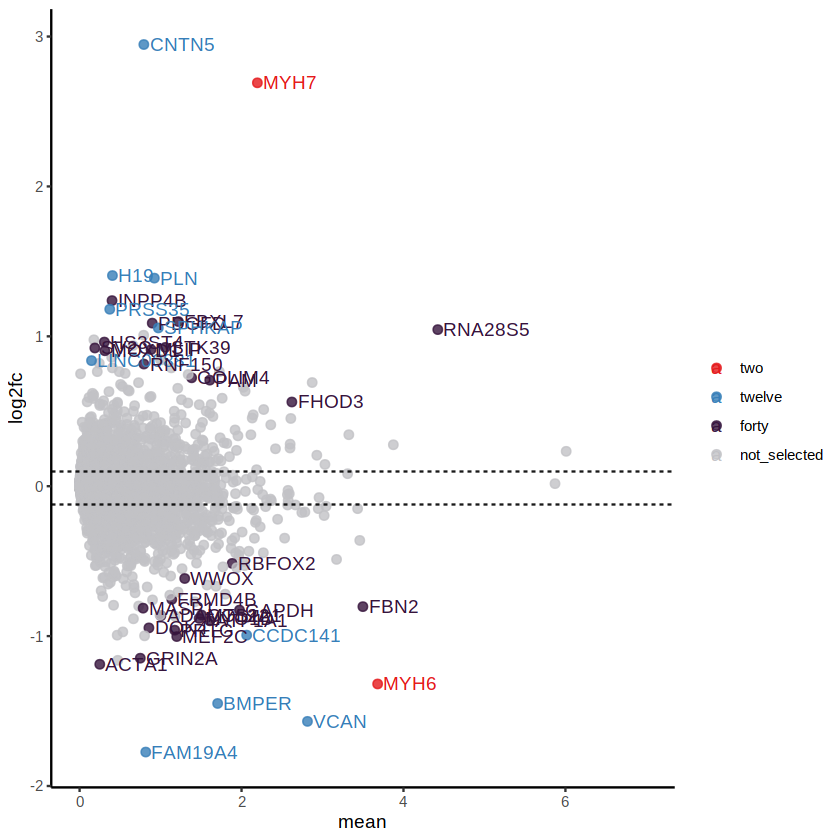

In [25]:
plot(all_selected_labeleled)

if (SAVE) {
    ggsave(all_selected_labeleled, filename = glue("{SVG_DIR}/figure_3A_selected_genes_d12v24.svg"), device = "svg", width = 10, height=10, dpi = 300)
    ggsave(all_selected_labeleled, filename = glue("{PNG_DIR}/figure_3A_selected_genes_d12v24.png"), device = "png", width = 5, height=5, dpi = 300)
}

***
#### Age prediction accuracy

In [26]:
all_stats_df = read.csv("../feature_selection/lambda_sequence_stats_glmnet_ALL_20200123.csv")
random_df = read.csv("../feature_selection/random_gene_stats_glmnet_20200123.csv")

In [27]:
head(all_stats_df)

,X,Sensitivity,Specificity,Pos.Pred.Value,Neg.Pred.Value,Precision,Recall,F1,Prevalence,Detection.Rate,⋯,Balanced.Accuracy,Accuracy,Kappa,AccuracyLower,AccuracyUpper,AccuracyNull,AccuracyPValue,McnemarPValue,ngenes,gene_type
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,lambda2,0.8835759,0.6387665,0.8382643,0.7213930,0.8382643,0.8835759,0.8603239,0.6793785,0.6002825,⋯,0.7611712,0.8050847,0.5386315,0.7739521,0.8336493,0.6793785,4.871042e-14,0.033325368,1,selection
2,lambda3,0.9209979,0.6828194,0.8601942,0.8031088,0.8601942,0.9209979,0.8895582,0.6793785,0.6257062,⋯,0.8019087,0.8446328,0.6286796,0.8158147,0.8705416,0.6793785,7.831379e-24,0.001652788,2,selection
3,lambda4,0.9209979,0.6828194,0.8601942,0.8031088,0.8601942,0.9209979,0.8895582,0.6793785,0.6257062,⋯,0.8019087,0.8446328,0.6286796,0.8158147,0.8705416,0.6793785,7.831379e-24,0.001652788,2,selection
4,lambda5,0.9313929,0.7621145,0.8924303,0.8398058,0.8924303,0.9313929,0.9114954,0.6793785,0.6327684,⋯,0.8467537,0.8771186,0.7108712,0.8506478,0.9003954,0.6793785,1.409784e-34,0.032014857,3,selection
5,lambda6,0.9313929,0.7621145,0.8924303,0.8398058,0.8924303,0.9313929,0.9114954,0.6793785,0.6327684,⋯,0.8467537,0.8771186,0.7108712,0.8506478,0.9003954,0.6793785,1.409784e-34,0.032014857,3,selection
6,lambda7,0.9313929,0.7621145,0.8924303,0.8398058,0.8924303,0.9313929,0.9114954,0.6793785,0.6327684,⋯,0.8467537,0.8771186,0.7108712,0.8506478,0.9003954,0.6793785,1.409784e-34,0.032014857,3,selection


### Figure 3B Plot random and selected genes accuracy

In [28]:
combined_stats = rbind(unique(all_stats_df), random_df)

In [29]:
combined_stats$break_axis = FALSE

In [30]:
combined_stats[combined_stats$ngenes %in% c(1877), ][, "break_axis"] = TRUE

In [31]:
plotting_error_80 = combined_stats[combined_stats$break_axis == FALSE, ] %>%
    group_by(gene_type, ngenes) %>%
    summarise(mean_acc = mean(Accuracy),
              sd_acc = sd(Accuracy),
              len_acc = n(),
              se_acc = sd(Accuracy) / sqrt(n())
              )

In [32]:
color_df = data.frame(
    ngenes = c(2, 12, 40),
    color_group = c("two", "twelve", "forty")
)

In [33]:
merged_for_plotting_all = merge(x = combined_stats %>% filter(ngenes %in% 1:83), y = color_df, all = TRUE)

In [34]:
merged_for_plotting_all = merged_for_plotting_all %>% mutate(color_group = replace(color_group, is.na(color_group), "other"))

In [35]:
head(merged_for_plotting_all)

,ngenes,X,Sensitivity,Specificity,Pos.Pred.Value,Neg.Pred.Value,Precision,Recall,F1,Prevalence,⋯,Accuracy,Kappa,AccuracyLower,AccuracyUpper,AccuracyNull,AccuracyPValue,McnemarPValue,gene_type,break_axis,color_group
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<chr>
1,1,lambda2,0.8835759,0.63876652,0.8382643,0.7213930,0.8382643,0.8835759,0.8603239,0.6793785,⋯,0.8050847,0.538631534,0.7739521,0.8336493,0.6793785,4.871042e-14,3.332537e-02,selection,FALSE,other
2,1,random1_1,0.9896050,0.04405286,0.6868687,0.6666667,0.6868687,0.9896050,0.8109029,0.6793785,⋯,0.6864407,0.044673790,0.6508357,0.7204832,0.6793785,3.601216e-01,1.588151e-45,random,FALSE,other
3,1,random1_2,0.9979210,0.00000000,0.6789250,0.0000000,0.6789250,0.9979210,0.8080808,0.6793785,⋯,0.6779661,-0.002820401,0.6421534,0.7122877,0.6793785,5.499437e-01,3.247368e-50,random,FALSE,other
4,1,random1_3,1.0000000,0.00000000,0.6793785,NA,0.6793785,1.0000000,0.8090833,0.6793785,⋯,0.6793785,0.000000000,0.6435995,0.7136545,0.6793785,5.179732e-01,7.325707e-51,random,FALSE,other
5,1,random1_4,1.0000000,0.00000000,0.6793785,NA,0.6793785,1.0000000,0.8090833,0.6793785,⋯,0.6793785,0.000000000,0.6435995,0.7136545,0.6793785,5.179732e-01,7.325707e-51,random,FALSE,other
6,1,random1_5,1.0000000,0.00000000,0.6793785,NA,0.6793785,1.0000000,0.8090833,0.6793785,⋯,0.6793785,0.000000000,0.6435995,0.7136545,0.6793785,5.179732e-01,7.325707e-51,random,FALSE,other


Also skip some gene sets so that points can be a bit bigger

In [36]:
ngenes_all = unique(merged_for_plotting_all$ngenes)

In [37]:
show_genes = c(ngenes_all[1:9], ngenes_all[10:length(ngenes_all)][c(FALSE, TRUE)])

Skipping genes sets but keeping boxplots

In [38]:
p1 = ggplot(merged_for_plotting_all, aes(x = ngenes, y = Accuracy, group = factor(gene_type, levels = c("random", "selection")))) +
    geom_point(data = merged_for_plotting_all %>% filter(gene_type == "selection" & ngenes %in% show_genes), aes(color = color_group), size = 5, alpha = 0.8) +
    geom_boxplot(data = merged_for_plotting_all %>% filter(gene_type == "random" & ngenes %in% show_genes), aes(group = interaction(gene_type, ngenes), color = color_group), outlier.shape = 1, outlier.alpha = 0, width = 1) +
    scale_color_manual(name = "",
                         breaks = c("two", "twelve", "forty", "other"), 
                         values = c("two" = "#E41A1C",
                                    "twelve" = "#377EB8",
                                    "forty" = "#36143C",
                                    "other" = "#C1C1C5"
                                  )) +
    geom_hline(yintercept = 0.68, linetype = "dashed", color = "black") +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(color = "black")) +
    xlab("Gene set size") +
    ylab("Prediction accuracy") +
    ylim(c(0.65, 1)) +
    theme(legend.position = "none") +
    theme(text = element_text(size = 18), axis.text = element_text(size = 15))

Add p2 with boxplot

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”


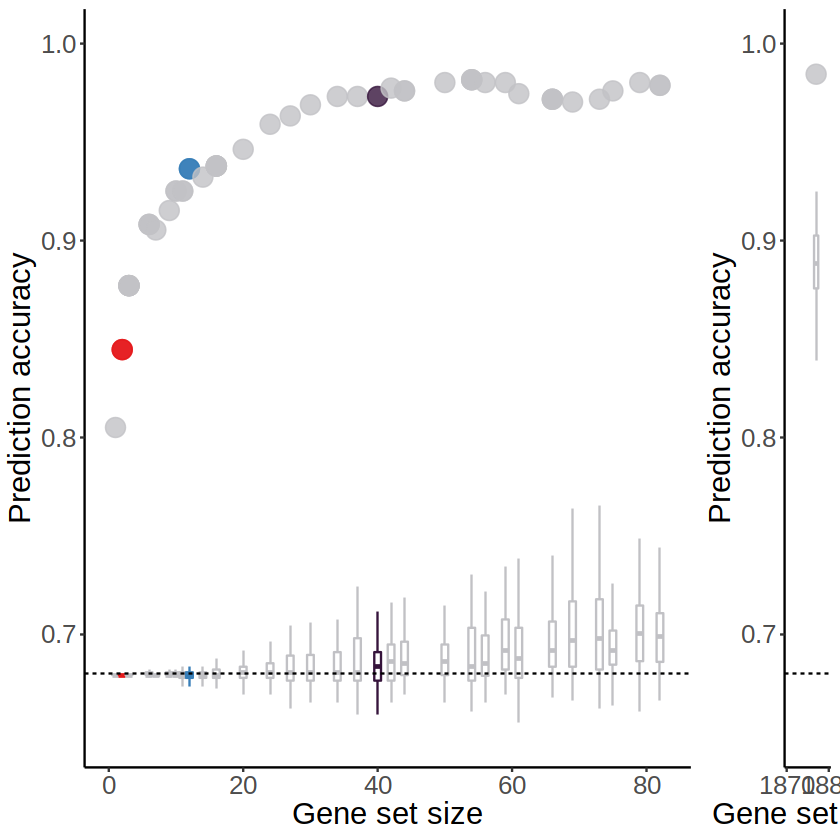

In [39]:
p2 = ggplot(combined_stats %>% filter(break_axis == TRUE & ngenes == 1877), aes(x = ngenes, y = Accuracy, group = factor(gene_type, levels = c("random", "highly_var")))) +
    geom_point(data = combined_stats %>% filter(break_axis == TRUE & ngenes == 1877 & gene_type == "highly_var"), color = "#C1C1C5", size = 5, alpha = 0.8) +
    geom_boxplot(data = combined_stats %>% filter(break_axis == TRUE & ngenes == 1877 & gene_type == "random"), aes(group = interaction(gene_type, ngenes)), color = "#C1C1C5", width = 1, outlier.shape = 1, outlier.alpha = 0) +
    scale_x_continuous(limits = c(1870, 1880), breaks = seq(1870, 1880, 10)) +
    geom_hline(yintercept = 0.68, linetype = "dashed", color = "black") +
    ylim(c(0.65, 1)) +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
    xlab("Gene set size") +
    ylab("Prediction accuracy") +
    theme(legend.position = "none") +
    theme(text = element_text(size = 18), axis.text = element_text(size = 15))

p.accuracy = grid.arrange(p1, p2, widths=c(5, 1))

if (SAVE) {
    ggsave(p.accuracy, filename = glue("{SVG_DIR}/figure_3B_selected_gene_accuracy_d12v24.svg"), device = "svg", width = 8, height=5, dpi = 300, unit="in")
    ggsave(p.accuracy, filename = glue("{PNG_DIR}/figure_3B_selected_gene_accuracy_d12v24.png"), device = "png", width = 8, height=5, dpi = 300, unit="in")
}

***
### Supp Figure 4A

In [40]:
load("../feature_selection/feature_selection_frequency.RData")

Add column to color code by selection status

In [41]:
selected_gene_groups = read.csv("../feature_selection/selected_gene_groups.csv")

In [42]:
final_gene_frame_selected = merge(final_gene_frame, selected_gene_groups, by.x = "Var1", by.y = "gene_human", all.x = TRUE, sort = FALSE)

In [43]:
final_gene_frame_selected$group[is.na(final_gene_frame_selected$group)] <- "not_selected"

In [44]:
max(log(final_gene_frame_selected$lambda))
min(log(final_gene_frame_selected$lambda))

[1] -0.6226364

[1] -5.440616

In [45]:
p.boots_selection_freq <- ggplot(final_gene_frame_selected, aes(x = log(lambda), y = Freq, color = group, group = Var1, alpha = group == "not_selected")) +
    geom_line(size=1) +
     scale_color_manual(name = "",
                         breaks = c("two", "twelve", "forty", "not_selected"), 
                         values = c("two" = "#E41A1C",
                                    "twelve" = "#377EB8",
                                    "forty" = "#36143C",
                                    "not_selected" = "#C1C1C5"
                                  )) +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
    guides(color = guide_legend(override.aes = list(size=4))) +
    theme(legend.text = element_text(size = 13), legend.title=element_text(size=14)) + 
    geom_vline(xintercept = log(0.0494252988), alpha = 0.9, linetype = 2) +
    ylab("# of times selected in 1000 bootstraps") +
    scale_alpha_manual(values = c(1, 0.1), guide = FALSE) +
    scale_x_continuous(limits = c(-5.5, -0.5), expand = c(0, 0)) +
    scale_y_continuous(limits = c(0, 1000), expand = c(0, 0))

if (SAVE) {
    ggsave(p.boots_selection_freq, filename = glue("{SVG_DIR}/supp_figure_4A_selected_genes_boots_freq.svg"), device = "svg", width = 8, height=5, dpi = 300)
    ggsave(p.boots_selection_freq, filename = glue("{PNG_DIR}/supp_figure_4A_selected_genes_boots_freq.png"), device = "png", width = 8, height=5, dpi = 300)
}

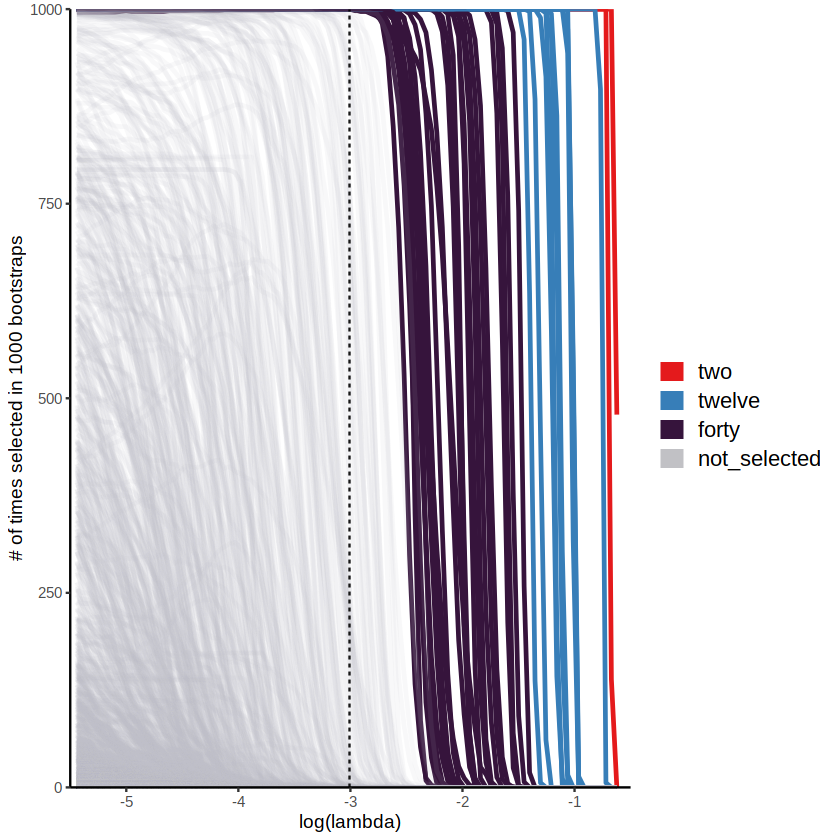

In [46]:
plot(p.boots_selection_freq)

### Supp Figure 4B

In [47]:
# how many genes are selected at each lambda
all_lambda = unique(final_gene_frame$lambda)

selected_at_lambda = lapply(1:length(all_lambda), function(k) {
    this_lambda = final_gene_frame[final_gene_frame$lambda == all_lambda[k], ]
    #unique(this_lambda$lambda)
    selected_this_lambda = this_lambda[this_lambda$Freq == 1000, ]
    gene_names = selected_this_lambda$Var1
    if (length(gene_names) < 1){
        gene_df = data.frame("gene" = c(0), "lambda" = all_lambda[k])

    } else {
        gene_df = data.frame("gene" = as.character(gene_names), "lambda" = all_lambda[k])
 
    }
    return(as.data.frame(gene_df))
    
}
       )

In [48]:
gene_df = do.call(rbind, selected_at_lambda)

In [49]:
lambda_color_df = data.frame(
    lambda = c(lambda_seq[3], lambda_seq[13], lambda_seq[50]),
    color_group = c("two", "twelve", "forty")
)

In [50]:
lambda_gene_count = gene_df %>% filter(gene != 0) %>% count(lambda)

In [51]:
gene_df = merge(x = lambda_gene_count, y = lambda_color_df, by = "lambda", all = TRUE)

In [52]:
gene_df = gene_df %>% mutate(color_group = replace(color_group, is.na(color_group), "other"))

In [53]:
max(log(gene_df$lambda))
min(log(gene_df$lambda))

[1] -0.6713028

[1] -5.440616

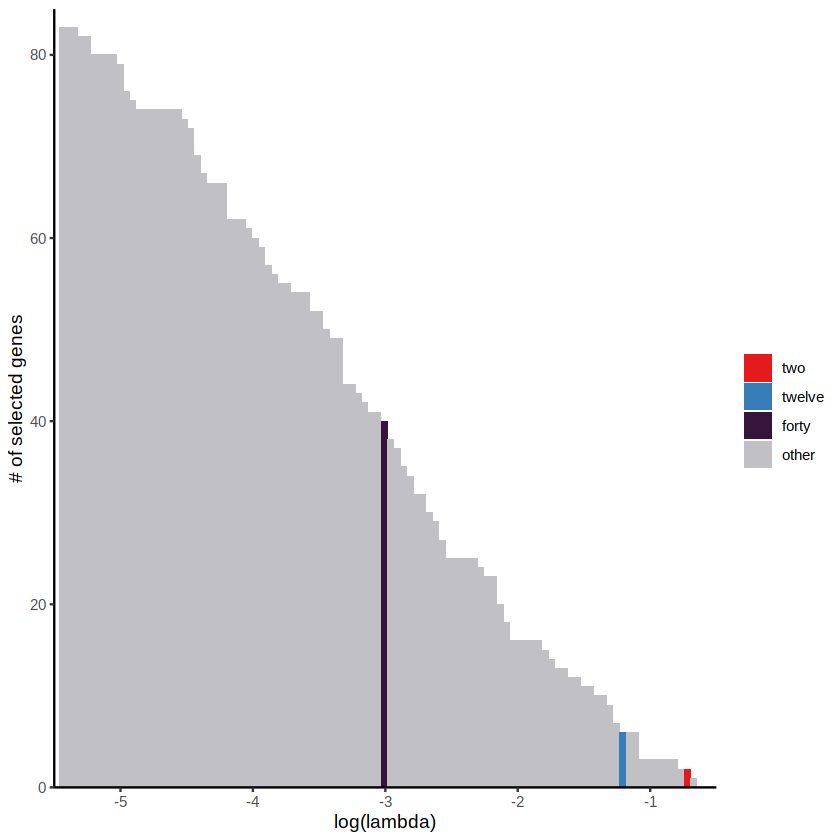

In [54]:
p_selected_per_labmda_log = ggplot(gene_df, aes(x = log(lambda), y = n, fill = color_group)) + geom_col(orientation="x") +
     scale_fill_manual(name = "",
                         breaks = c("two", "twelve", "forty", "other"), 
                         values = c("two" = "#E41A1C",
                                    "twelve" = "#377EB8",
                                    "forty" = "#36143C",
                                    "other" = "#C1C1C5"
                                  )) +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
    scale_x_continuous(limits = c(-5.5, -0.5), expand = c(0, 0)) +
    scale_y_continuous(limits = c(0, 85), expand = c(0, 0)) +
    ylab("# of selected genes")

plot(p_selected_per_labmda_log)

if (SAVE) {
    ggsave(p_selected_per_labmda_log, filename = glue("{SVG_DIR}/supp_figure_4B_num_selected_genes.svg"), device = "svg", width = 8, height=5, dpi = 300)
    ggsave(p_selected_per_labmda_log, filename = glue("{PNG_DIR}/supp_figure_4B_num_selected_genes.png"), device = "png", width = 8, height=5, dpi = 300)
}

### Protocol 1 D24 vs. D90 feature selection

In [55]:
load("/allen/aics/gene-editing/RNA_seq/scRNAseq_SeeligCollaboration/2019_analysis/feature_selection/train_cm_entrez_only_normalized_counts_D24_D90.RData")

In [56]:
cell_metadata <- read.csv("/allen/aics/gene-editing/RNA_seq/scRNAseq_SeeligCollaboration/2019_analysis/feature_selection/train_cm_entrez_only_metadata_D24_D90.csv")

In [57]:
base_dir <- "/allen/aics/gene-editing/RNA_seq/scRNAseq_SeeligCollaboration/2019_analysis/feature_selection/"

In [58]:
load(paste0(base_dir, "results/D24_D90_small_mol.RData"))

In [59]:
lambda_sequence <- bootstraps[[1]][["lambda"]]
genes <- rownames(coef(bootstraps[[1]], s = lambda_sequence[1]))

In [60]:
genes <- genes[2:length(genes)]
length(genes)
num_genes <- length(genes)

[1] 23151

In [61]:
nonzero_gene_count <- c()
lambda <- lambda_sequence[49]

genes_coeff <- coef(bootstraps[[1]], s = lambda)
genes_coeff <- genes_coeff[2:length(genes_coeff),]
gene_names <- names(genes_coeff)
genes_nonzero <- gene_names[abs(genes_coeff) > 0]
nonzero_gene_count <- c(nonzero_gene_count, length(genes_nonzero))

genes_intersect <- genes_nonzero

for (i in 2:length(bootstraps)) {
    lambda_seq <- bootstraps[[i]][["lambda"]]
    if (lambda < tail(lambda_seq, n = 1)) {
        print(i)
    } 
    genes_coeff <- coef(bootstraps[[i]], s = lambda)
    genes_coeff <- genes_coeff[2:length(genes_coeff),]
    gene_names <- names(genes_coeff)
    genes_nonzero <- gene_names[abs(genes_coeff) > 0]
    nonzero_gene_count <- c(nonzero_gene_count, length(genes_nonzero))
    genes_intersect <- intersect(genes_intersect, genes_nonzero)
}

Genes selected in all 1000 bootstrap rounds

In [62]:
print(lambda_sequence[49])
print(length(genes_intersect))

[1] 0.08083869
[1] 40


In [63]:
selected_gene_df <- data.frame(gene = sapply(genes_intersect, get_gene_name))
selected_gene_df

,gene
,<chr>
NLGN1_HUMAN,NLGN1
ALPK2_HUMAN,ALPK2
MYH6_HUMAN,MYH6
SC5D_HUMAN,SC5D
COL2A1_HUMAN,COL2A1
PDE3A_HUMAN,PDE3A
CALD1_HUMAN,CALD1
PRKG1_HUMAN,PRKG1
PRTG_HUMAN,PRTG


In [64]:
write.csv(selected_gene_df, file = "feature_selected_genes_d24_d90.csv")

In [65]:
selected_gene_group = read.csv("../feature_selection/selected_gene_groups_D24_D90.csv")

### Supp Figure 4C

In [66]:
cardio = t(cardio)
small_mol_cells <- cell_metadata$protocol_final == "SM"
cardio <- cardio[small_mol_cells,, drop = FALSE]

late_cells <- cell_metadata$X[cell_metadata$day %in% c("D93", "D96")]
early_cells <- cell_metadata$X[cell_metadata$day %in% c("D24")]

early_exp_mat <- cardio[early_cells,, drop = FALSE]
late_exp_mat <- cardio[late_cells,, drop = FALSE]

mean_early <- apply(early_exp_mat, MARGIN = 2, function(x) log2(mean(expm1(x)) + 1))
mean_late <- apply(late_exp_mat, MARGIN = 2, function(x) log2(mean(expm1(x)) + 1))

log2lfc <- mean_late - mean_early

mean_all <- apply(cardio, MARGIN = 2, function(x) mean(expm1(x)))

In [67]:
mean_all_norm <- apply(cardio, MARGIN = 2, function(x) mean(x))

In [68]:
identical(colnames(early_exp_mat), colnames(late_exp_mat))
identical(colnames(early_exp_mat), names(mean_all_norm))

[1] TRUE

[1] TRUE

In [69]:
identical(genes, names(mean_all_norm))

[1] TRUE

In [70]:
lfc_df <- data.frame("gene" = genes, "mean" = mean_all_norm, "log2fc" = log2lfc)
lfc_df <- dplyr::arrange(lfc_df, log2fc)

In [71]:
merged_lfc_df = merge(lfc_df, selected_gene_group, by.x = "gene", by.y = "gene_human", all = TRUE)

In [72]:
merged_lfc_df$gene_name <- sapply(merged_lfc_df$gene, get_gene_name)

In [73]:
merged_lfc_df = merged_lfc_df %>% mutate(group = replace(group, is.na(group), "not_selected"))

In [74]:
all_selected_labeleled_d24_90 = ggplot(merged_lfc_df, aes(x = mean, y = log2fc, color = group, label = gene.y)) +
    geom_point(alpha = 0.8, size = 2) +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
    scale_color_manual(name = "",
                         breaks = c("three", "twelve", "forty", "not_selected"), 
                         values = c("three" = "#E41A1C",
                                    "twelve" = "#377EB8",
                                    "forty" = "#36143C",
                                  "not_selected" = "#C1C1C5"
                                  )) +
    geom_hline(yintercept = quantile(lfc_df$log2fc, 0.95), alpha = 0.9, linetype = 2) +
    geom_hline(yintercept = quantile(lfc_df$log2fc, 0.05), alpha = 0.9, linetype = 2) +
    geom_text(check_overlap = FALSE, size = 4, hjust = 0, nudge_x = 0.07) +
    xlim(0, 7)

all_selected_d24_90 = ggplot(merged_lfc_df, aes(x = mean, y = log2fc, color = group)) +
    geom_point(alpha = 0.8, size = 2) +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
    scale_color_manual(name = "",
                         breaks = c("three", "twelve", "forty", "not_selected"), 
                         values = c("three" = "#E41A1C",
                                    "twelve" = "#377EB8",
                                    "forty" = "#36143C",
                                  "not_selected" = "#C1C1C5"
                                  )) +
    geom_hline(yintercept = quantile(lfc_df$log2fc, 0.95), alpha = 0.9, linetype = 2) +
    geom_hline(yintercept = quantile(lfc_df$log2fc, 0.05), alpha = 0.9, linetype = 2) +
    xlim(0, 7)

Warning message:
“Removed 23111 rows containing missing values (geom_text).”
Warning message:
“Removed 23111 rows containing missing values (geom_text).”
Warning message:
“Removed 23111 rows containing missing values (geom_text).”


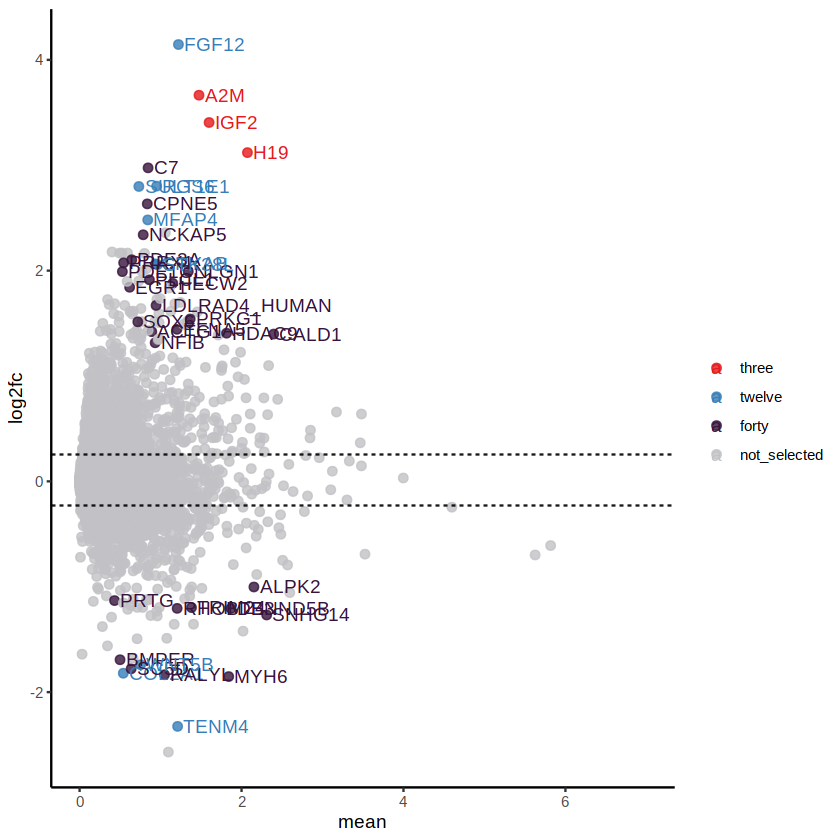

In [75]:
plot(all_selected_labeleled_d24_90)

if (SAVE) {
    ggsave(all_selected_labeleled_d24_90, filename = glue("{SVG_DIR}/supp_figure_4C_selected_genes_d24v90.svg"), device = "svg", width = 10, height=10, dpi = 300)
    ggsave(all_selected_labeleled_d24_90, filename = glue("{PNG_DIR}/supp_figure_4C_selected_genes_d124v90.png"), device = "png", width = 5, height=5, dpi = 300)
}

***
#### Age prediction accuracy

In [76]:
all_stats_df = read.csv("../feature_selection/lambda_sequence_stats_glmnet_D24_D90_ALL_20210201.csv")
random_df = read.csv("../feature_selection/random_gene_stats_glmnet_D24_D90_ALL_20210201.csv")

In [77]:
head(all_stats_df)

,X,Sensitivity,Specificity,Pos.Pred.Value,Neg.Pred.Value,Precision,Recall,F1,Prevalence,Detection.Rate,⋯,Balanced.Accuracy,Accuracy,Kappa,AccuracyLower,AccuracyUpper,AccuracyNull,AccuracyPValue,McnemarPValue,ngenes,gene_type
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,lambda2,0.9162996,0.9011858,0.8927039,0.9230769,0.8927039,0.9162996,0.9043478,0.4729167,0.4333333,⋯,0.9087427,0.9083333,0.8163766,0.8788967,0.9326044,0.5270833,1.407379e-73,0.4509823,1,selection
2,lambda3,0.9162996,0.9011858,0.8927039,0.9230769,0.8927039,0.9162996,0.9043478,0.4729167,0.4333333,⋯,0.9087427,0.9083333,0.8163766,0.8788967,0.9326044,0.5270833,1.407379e-73,0.4509823,1,selection
3,lambda4,0.9471366,0.9249012,0.9188034,0.9512195,0.9188034,0.9471366,0.9327549,0.4729167,0.4479167,⋯,0.9360189,0.9354167,0.8706582,0.9095789,0.9557005,0.5270833,7.083400e-87,0.2811981,3,selection
4,lambda5,0.9735683,0.9446640,0.9404255,0.9755102,0.9404255,0.9735683,0.9567100,0.4729167,0.4604167,⋯,0.9591162,0.9583333,0.9165725,0.9363808,0.9743662,0.5270833,4.426338e-100,0.1175249,5,selection
5,lambda6,0.9735683,0.9446640,0.9404255,0.9755102,0.9404255,0.9735683,0.9567100,0.4729167,0.4604167,⋯,0.9591162,0.9583333,0.9165725,0.9363808,0.9743662,0.5270833,4.426338e-100,0.1175249,5,selection
6,lambda7,0.9735683,0.9446640,0.9404255,0.9755102,0.9404255,0.9735683,0.9567100,0.4729167,0.4604167,⋯,0.9591162,0.9583333,0.9165725,0.9363808,0.9743662,0.5270833,4.426338e-100,0.1175249,5,selection


### Supp Figure 4D Plot random and selected genes accuracy

In [78]:
combined_stats = rbind(unique(all_stats_df), random_df)

In [79]:
combined_stats$break_axis = FALSE

In [80]:
combined_stats[combined_stats$ngenes %in% c(1812), ][, "break_axis"] = TRUE

In [81]:
color_df = data.frame(
    ngenes = c(3, 12, 40),
    color_group = c("three", "twelve", "forty")
)

In [82]:
merged_for_plotting_all = merge(x = combined_stats %>% filter(ngenes %in% 1:68), y = color_df, all = TRUE)

In [83]:
merged_for_plotting_all = merged_for_plotting_all %>% mutate(color_group = replace(color_group, is.na(color_group), "other"))

In [84]:
head(merged_for_plotting_all)

,ngenes,X,Sensitivity,Specificity,Pos.Pred.Value,Neg.Pred.Value,Precision,Recall,F1,Prevalence,⋯,Accuracy,Kappa,AccuracyLower,AccuracyUpper,AccuracyNull,AccuracyPValue,McnemarPValue,gene_type,break_axis,color_group
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<chr>
1,1,lambda2,0.9162996,0.9011858,0.8927039,0.9230769,0.8927039,0.9162996,0.9043478,0.4729167,⋯,0.9083333,0.8163766,0.8788967,0.9326044,0.5270833,1.407379e-73,4.509823e-01,selection,FALSE,other
2,1,lambda3,0.9162996,0.9011858,0.8927039,0.9230769,0.8927039,0.9162996,0.9043478,0.4729167,⋯,0.9083333,0.8163766,0.8788967,0.9326044,0.5270833,1.407379e-73,4.509823e-01,selection,FALSE,other
3,1,random1_1,0.5594714,0.7944664,0.7094972,0.6677741,0.7094972,0.5594714,0.6256158,0.4729167,⋯,0.6833333,0.3578256,0.6396413,0.7247490,0.5270833,2.481652e-12,1.377335e-04,random,FALSE,other
4,1,random1_2,0.0000000,1.0000000,NA,0.5270833,NA,0.0000000,NA,0.4729167,⋯,0.5270833,0.0000000,0.4813282,0.5725029,0.5270833,5.185549e-01,7.325707e-51,random,FALSE,other
5,1,random1_3,0.0000000,1.0000000,NA,0.5270833,NA,0.0000000,NA,0.4729167,⋯,0.5270833,0.0000000,0.4813282,0.5725029,0.5270833,5.185549e-01,7.325707e-51,random,FALSE,other
6,1,random1_4,0.0000000,1.0000000,NA,0.5270833,NA,0.0000000,NA,0.4729167,⋯,0.5270833,0.0000000,0.4813282,0.5725029,0.5270833,5.185549e-01,7.325707e-51,random,FALSE,other


Also skip some gene sets so that points can be a bit bigger

In [85]:
ngenes_all = unique(merged_for_plotting_all$ngenes)

In [86]:
show_genes = c(ngenes_all[1:9], ngenes_all[10:length(ngenes_all)][c(FALSE, TRUE)])

Skipping genes sets but keeping boxplots

In [87]:
p1 = ggplot(merged_for_plotting_all, aes(x = ngenes, y = Accuracy, group = factor(gene_type, levels = c("random", "selection")))) +
    geom_point(data = merged_for_plotting_all %>% filter(gene_type == "selection" & ngenes %in% show_genes), aes(color = color_group), size = 5, alpha = 0.8) +
    geom_boxplot(data = merged_for_plotting_all %>% filter(gene_type == "random" & ngenes %in% show_genes), aes(group = interaction(gene_type, ngenes), color = color_group), outlier.shape = 1, outlier.alpha = 0, width = 1) +
    scale_color_manual(name = "",
                         breaks = c("three", "twelve", "forty", "other"), 
                         values = c("three" = "#E41A1C",
                                    "twelve" = "#377EB8",
                                    "forty" = "#36143C",
                                    "other" = "#C1C1C5"
                                  )) +
    #geom_hline(yintercept = 0.68, linetype = "dashed", color = "black") +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(color = "black")) +
    xlab("Gene set size") +
    ylab("Prediction accuracy") +
    ylim(c(0.4, 1)) +
    theme(legend.position = "none") +
    theme(text = element_text(size = 18), axis.text = element_text(size = 15))

Add p2 with boxplot

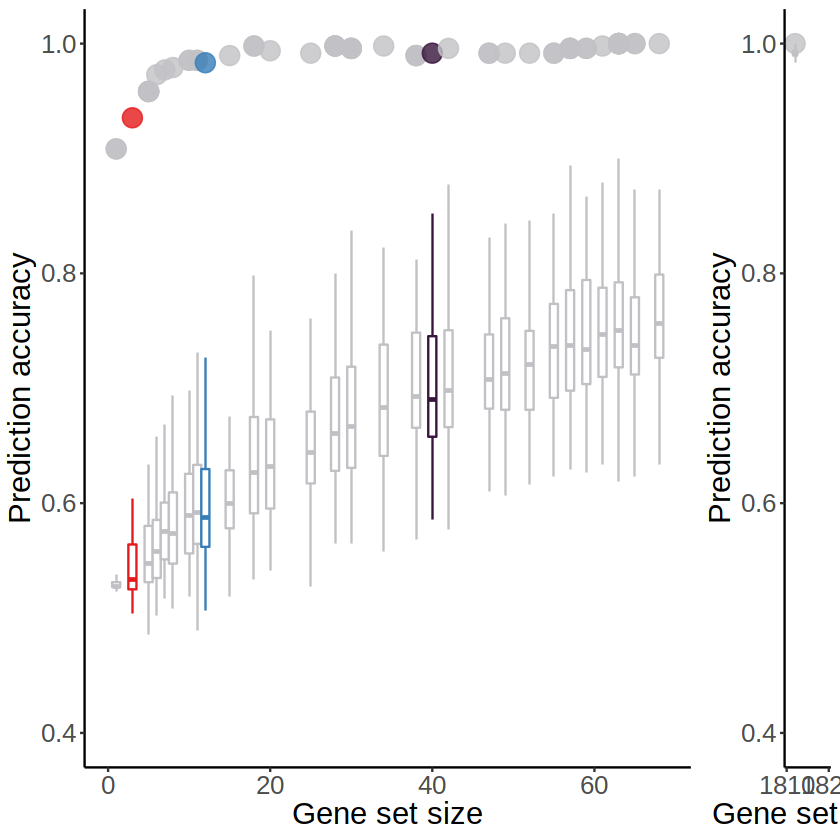

In [88]:
p2 = ggplot(combined_stats %>% filter(break_axis == TRUE & ngenes == 1812), aes(x = ngenes, y = Accuracy, group = factor(gene_type, levels = c("random", "highly_var")))) +
    geom_point(data = combined_stats %>% filter(break_axis == TRUE & ngenes == 1812 & gene_type == "highly_var"), color = "#C1C1C5", size = 5, alpha = 0.8) +
    geom_boxplot(data = combined_stats %>% filter(break_axis == TRUE & ngenes == 1812 & gene_type == "random"), aes(group = interaction(gene_type, ngenes)), color = "#C1C1C5", width = 1, outlier.shape = 1, outlier.alpha = 0) +
    scale_x_continuous(limits = c(1810, 1820), breaks = seq(1810, 1820, 10)) +
    #geom_hline(yintercept = 0.68, linetype = "dashed", color = "black") +
    ylim(c(0.4, 1)) +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
    xlab("Gene set size") +
    ylab("Prediction accuracy") +
    theme(legend.position = "none") +
    theme(text = element_text(size = 18), axis.text = element_text(size = 15))

p.accuracy = grid.arrange(p1, p2, widths=c(5, 1))

if (SAVE) {
    ggsave(p.accuracy, filename = glue("{SVG_DIR}/supp_figure_4D_selected_gene_accuracy_d12v24.svg"), device = "svg", width = 8, height=5, dpi = 300, unit="in")
    ggsave(p.accuracy, filename = glue("{PNG_DIR}/supp_figure_4D_selected_gene_accuracy_d12v24.png"), device = "png", width = 8, height=5, dpi = 300, unit="in")
}

***
### Supp Figure 4F

In [89]:
load("../feature_selection/feature_selection_frequency_d24_d90.RData")

Add column to color code by selection status

In [90]:
selected_gene_groups = read.csv("../feature_selection/selected_gene_groups_D24_D90.csv")

In [91]:
final_gene_frame_selected = merge(final_gene_frame, selected_gene_groups, by.x = "Var1", by.y = "gene_human", all.x = TRUE, sort = FALSE)

In [92]:
final_gene_frame_selected$group[is.na(final_gene_frame_selected$group)] <- "not_selected"

In [93]:
max(log(final_gene_frame_selected$lambda))
min(log(final_gene_frame_selected$lambda))

[1] -0.2824899

[1] -4.88766

In [94]:
p.boots_selection_freq_24v90 <- ggplot(final_gene_frame_selected, aes(x = log(lambda), y = Freq, color = group, group = Var1, alpha = group == "not_selected")) +
    geom_line(size=1) +
     scale_color_manual(name = "",
                         breaks = c("three", "twelve", "forty", "not_selected"), 
                         values = c("three" = "#E41A1C",
                                    "twelve" = "#377EB8",
                                    "forty" = "#36143C",
                                    "not_selected" = "#C1C1C5"
                                  )) +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
    guides(color = guide_legend(override.aes = list(size=4))) +
    theme(legend.text = element_text(size = 13), legend.title=element_text(size=14)) + 
    geom_vline(xintercept = log(0.07716444), alpha = 0.9, linetype = 2) +
    ylab("# of times selected in 1000 bootstraps") +
    scale_alpha_manual(values = c(1, 0.1), guide = FALSE) +
    scale_x_continuous(limits = c(-5, -0.2), expand = c(0, 0)) +
    scale_y_continuous(limits = c(0, 1001), expand = c(0, 0))

if (SAVE) {
    ggsave(p.boots_selection_freq_24v90, filename = glue("{SVG_DIR}/supp_figure_4E_selected_genes_boots_freq_D24v90.svg"), device = "svg", width = 8, height=5, dpi = 300)
    ggsave(p.boots_selection_freq_24v90, filename = glue("{PNG_DIR}/supp_figure_4E_selected_genes_boots_freq_D24v90.png"), device = "png", width = 8, height=5, dpi = 300)
}

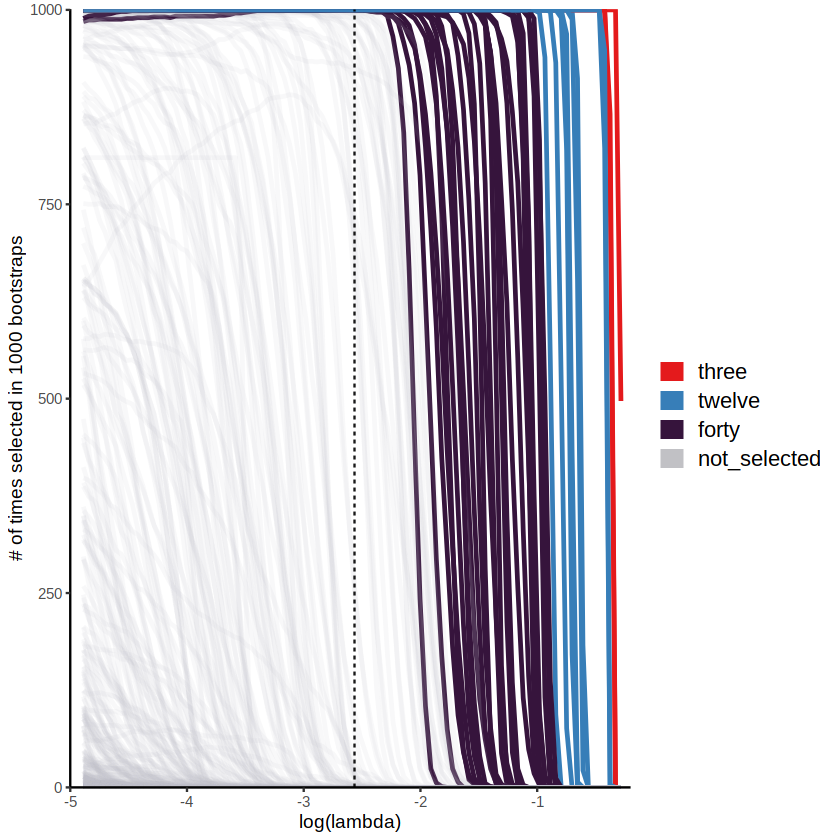

In [95]:
plot(p.boots_selection_freq_24v90)

### Supp Figure 4F

In [96]:
# how many genes are selected at each lambda
all_lambda = unique(final_gene_frame$lambda)

selected_at_lambda = lapply(1:length(all_lambda), function(k) {
    this_lambda = final_gene_frame[final_gene_frame$lambda == all_lambda[k], ]
    #unique(this_lambda$lambda)
    selected_this_lambda = this_lambda[this_lambda$Freq == 1000, ]
    gene_names = selected_this_lambda$Var1
    if (length(gene_names) < 1){
        gene_df = data.frame("gene" = c(0), "lambda" = all_lambda[k])

    } else {
        gene_df = data.frame("gene" = as.character(gene_names), "lambda" = all_lambda[k])
 
    }
    return(as.data.frame(gene_df))
    
}
       )

In [97]:
gene_df = do.call(rbind, selected_at_lambda)

In [98]:
lambda_color_df = data.frame(
    lambda = c(lambda_seq[2], lambda_seq[17], lambda_seq[49]),
    color_group = c("three", "twelve", "forty")
)

In [99]:
lambda_gene_count = gene_df %>% filter(gene != 0) %>% count(lambda)

In [100]:
gene_df = merge(x = lambda_gene_count, y = lambda_color_df, by = "lambda", all = TRUE)

In [101]:
gene_df = gene_df %>% mutate(color_group = replace(color_group, is.na(color_group), "other"))

In [102]:
max(log(gene_df$lambda))
min(log(gene_df$lambda))

[1] -0.3290067

[1] -4.88766

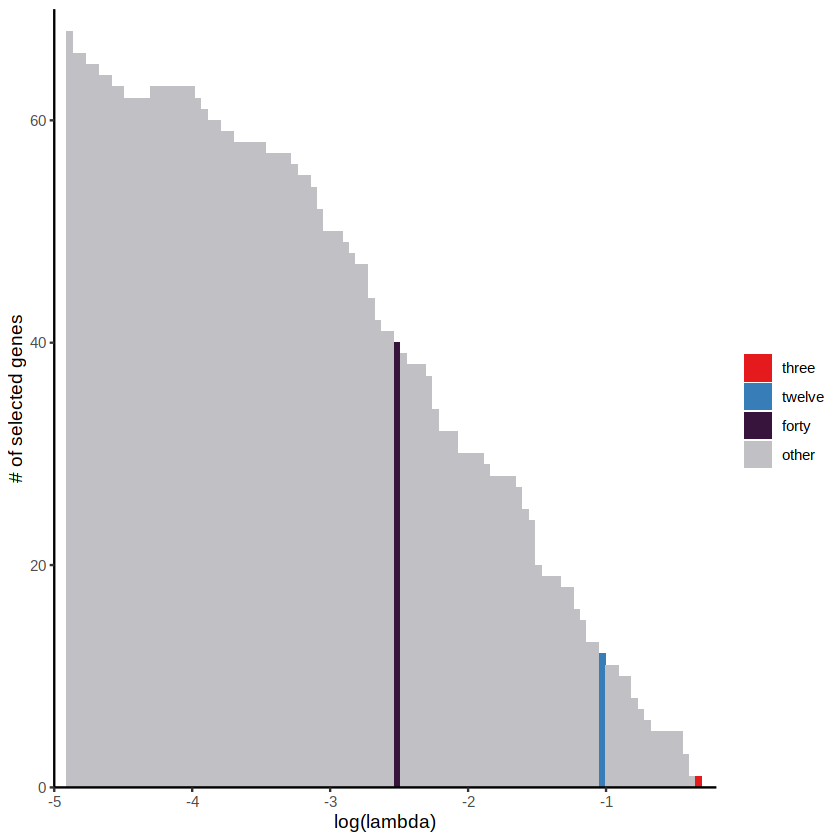

In [103]:
p_selected_per_labmda_log = ggplot(gene_df, aes(x = log(lambda), y = n, fill = color_group)) + geom_col(orientation="x") +
     scale_fill_manual(name = "",
                         breaks = c("three", "twelve", "forty", "other"), 
                         values = c("three" = "#E41A1C",
                                    "twelve" = "#377EB8",
                                    "forty" = "#36143C",
                                    "other" = "#C1C1C5"
                                  )) +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
    scale_x_continuous(limits = c(-5, -0.2), expand = c(0, 0)) +
    scale_y_continuous(limits = c(0, 70), expand = c(0, 0)) +
    ylab("# of selected genes")

plot(p_selected_per_labmda_log)

if (SAVE) {
    ggsave(p_selected_per_labmda_log, filename = glue("{SVG_DIR}/supp_figure_4F_num_selected_genes_24v90.svg"), device = "svg", width = 8, height=5, dpi = 300)
    ggsave(p_selected_per_labmda_log, filename = glue("{PNG_DIR}/supp_figure_4F_num_selected_genes_24v90.png"), device = "png", width = 8, height=5, dpi = 300)
}

### Protocol 2 D14 vs. D26 feature selection

In [104]:
load("/allen/aics/gene-editing/RNA_seq/scRNAseq_SeeligCollaboration/2019_analysis/feature_selection/train_cm_entrez_only_normalized_counts.RData")

In [105]:
cell_metadata <- read.csv("/allen/aics/gene-editing/RNA_seq/scRNAseq_SeeligCollaboration/2019_analysis/feature_selection/train_cm_entrez_only_metadata.csv")

In [135]:
test_train <- read.csv("/allen/aics/gene-editing/RNA_seq/scRNAseq_SeeligCollaboration/2019_analysis/feature_selection/train_cm_entrez_only_metadata.csv")

In [136]:
test_holdout <- read.csv("/allen/aics/gene-editing/RNA_seq/scRNAseq_SeeligCollaboration/2019_analysis/feature_selection/holdout_cm_entrez_only_metadata.csv")

In [137]:
table(test_train$day)


 D12  D14  D24  D26 
4283 4228 2014 2290 

In [138]:
table(test_holdout$day)


D12 D14 D24 D26 
481 476 227 259 

In [106]:
base_dir <- "/allen/aics/gene-editing/RNA_seq/scRNAseq_SeeligCollaboration/2019_analysis/feature_selection/"

In [107]:
load(paste0(base_dir, "results/early_late_cytokine.RData"))

In [108]:
lambda_sequence <- bootstraps[[1]][["lambda"]]
genes <- rownames(coef(bootstraps[[1]], s = lambda_sequence[1]))

In [109]:
genes <- genes[2:length(genes)]
length(genes)
num_genes <- length(genes)

[1] 23665

In [110]:
nonzero_gene_count <- c()
lambda <- lambda_sequence[43]

genes_coeff <- coef(bootstraps[[1]], s = lambda)
genes_coeff <- genes_coeff[2:length(genes_coeff),]
gene_names <- names(genes_coeff)
genes_nonzero <- gene_names[abs(genes_coeff) > 0]
nonzero_gene_count <- c(nonzero_gene_count, length(genes_nonzero))

genes_intersect <- genes_nonzero

for (i in 2:length(bootstraps)) {
    lambda_seq <- bootstraps[[i]][["lambda"]]
    if (lambda < tail(lambda_seq, n = 1)) {
        print(i)
    } 
    genes_coeff <- coef(bootstraps[[i]], s = lambda)
    genes_coeff <- genes_coeff[2:length(genes_coeff),]
    gene_names <- names(genes_coeff)
    genes_nonzero <- gene_names[abs(genes_coeff) > 0]
    nonzero_gene_count <- c(nonzero_gene_count, length(genes_nonzero))
    genes_intersect <- intersect(genes_intersect, genes_nonzero)
}

In [111]:
print(lambda_sequence[43])
print(length(genes_intersect))
genes_intersect

[1] 0.06948616
[1] 41


[1] "MAN1C1_HUMAN"    "MYH6_HUMAN"      "INPP4B_HUMAN"    "COL2A1_HUMAN"   
 [5] "ROBO2_HUMAN"     "FHOD3_HUMAN"     "GRIN2A_HUMAN"    "MYL4_HUMAN"     
 [9] "NAV1_HUMAN"      "PRTG_HUMAN"      "PLN_HUMAN"       "VCAN_HUMAN"     
[13] "MYO1D_HUMAN"     "CNTN5_HUMAN"     "PRICKLE1_HUMAN"  "SEMA3C_HUMAN"   
[17] "DAB1_HUMAN"      "BMPER_HUMAN"     "FAM19A4_HUMAN"   "GPC3_HUMAN"     
[21] "SAMD4A_HUMAN"    "ATP13A3_HUMAN"   "RBMS3_HUMAN"     "LSAMP_HUMAN"    
[25] "TANC2_HUMAN"     "MYH7_HUMAN"      "ITGAV_HUMAN"     "FBXL7_HUMAN"    
[29] "BMP2_HUMAN"      "RNF150_HUMAN"    "ADAM28_HUMAN"    "SDK1_HUMAN"     
[33] "MEF2C_HUMAN"     "H19_HUMAN"       "RBFOX2_HUMAN"    "FLRT2_HUMAN"    
[37] "LINC00881_HUMAN" "EZR_HUMAN"       "PIP4K2A_HUMAN"   "PRSS35_HUMAN"   
[41] "HECW2_HUMAN"

In [112]:
selected_gene_df <- data.frame(gene = sapply(genes_intersect, get_gene_name))
selected_gene_df

,gene
,<chr>
MAN1C1_HUMAN,MAN1C1
MYH6_HUMAN,MYH6
INPP4B_HUMAN,INPP4B
COL2A1_HUMAN,COL2A1
ROBO2_HUMAN,ROBO2
FHOD3_HUMAN,FHOD3
GRIN2A_HUMAN,GRIN2A
MYL4_HUMAN,MYL4
NAV1_HUMAN,NAV1


In [113]:
write.csv(selected_gene_df, file = "feature_selected_genes_cytokine_14_26.csv")

In [114]:
genes.use <- genes_intersect

cardio = t(cardio)
cytokine_cells <- cell_metadata$protocol_final == "C"
cardio <- cardio[cytokine_cells,, drop = FALSE]

late_cells <- cell_metadata$X[cell_metadata$day %in% c("D26")]
early_cells <- cell_metadata$X[cell_metadata$day %in% c("D14")]

early_exp_mat <- cardio[early_cells,, drop = FALSE]
late_exp_mat <- cardio[late_cells,, drop = FALSE]

mean_early <- apply(early_exp_mat, MARGIN = 2, function(x) log2(mean(expm1(x)) + 1))
mean_late <- apply(late_exp_mat, MARGIN = 2, function(x) log2(mean(expm1(x)) + 1))

log2lfc <- mean_late - mean_early

mean_all <- apply(cardio, MARGIN = 2, function(x) mean(expm1(x)))

In [115]:
mean_all_norm <- apply(cardio, MARGIN = 2, function(x) mean(x))

In [116]:
get_gene_status <- function(gene, selected) {
    if (gene %in% selected) {
        return("yes")
    } else {
        return("no")
    }
}

In [117]:
gene_status <- sapply(genes, get_gene_status, selected = genes.use)

In [118]:
identical(colnames(early_exp_mat), colnames(late_exp_mat))
identical(colnames(early_exp_mat), names(mean_all_norm))

[1] TRUE

[1] TRUE

In [119]:
identical(genes, names(mean_all_norm))

[1] TRUE

In [120]:
lfc_df <- data.frame("gene" = genes, "mean" = mean_all_norm, "log2fc" = log2lfc, "selected" = gene_status)
lfc_df <- dplyr::arrange(lfc_df, log2fc)

In [121]:
lfc_df$gene_name <- sapply(lfc_df$gene, get_gene_name)

In [122]:
lfc_df[which(lfc_df$selected=="yes"), "gene_name_selected"] = lfc_df$gene_name[which(lfc_df$selected=="yes")]

In [123]:
all_selected_labeleled_cytokine = ggplot(lfc_df, aes(x = mean, y = log2fc, color = selected, label = gene_name_selected)) +
    geom_point(alpha = 0.8, size = 2) +
    theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
    scale_color_manual(name = "",
                         breaks = c("yes", "no"), 
                         values = c("yes" = "black",
                                  "no" = "lightgray"
                                  )) +
    geom_hline(yintercept = quantile(lfc_df$log2fc, 0.95), alpha = 0.9, linetype = 2) +
    geom_hline(yintercept = quantile(lfc_df$log2fc, 0.05), alpha = 0.9, linetype = 2) +
    geom_text(check_overlap = FALSE, size = 4, hjust = 0, nudge_x = 0.07) +
    xlim(0, 7)

Warning message:
“Removed 23624 rows containing missing values (geom_text).”
Warning message:
“Removed 23624 rows containing missing values (geom_text).”
Warning message:
“Removed 23624 rows containing missing values (geom_text).”


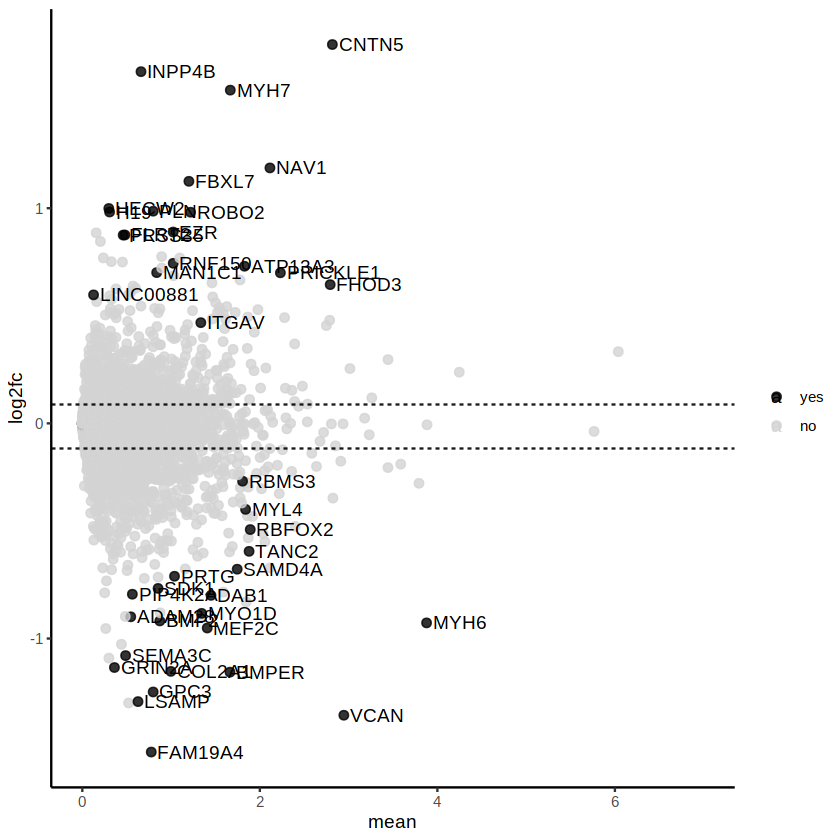

In [124]:
plot(all_selected_labeleled_cytokine)

if (SAVE) {
    ggsave(all_selected_labeleled_cytokine, filename = glue("{SVG_DIR}/supp_figure_7B_selected_genes_cytokine_D14v26.svg"), device = "svg", width = 10, height=10, dpi = 300)
    ggsave(all_selected_labeleled_cytokine, filename = glue("{PNG_DIR}/supp_figure_7B_selected_genes_cytokine_D14v26.png"), device = "png", width = 5, height=5, dpi = 300)
}